In [117]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import os.path as osp
import sys
#sys.path.insert(0, "/usr/users/vogg/FairMOT/own_ideas/")
#sys.path.insert(0, '/usr/users/vogg/FairMOT/src')
#sys.path.insert(0, '/usr/users/vogg/FairMOT/src/lib')
#sys.path.insert(0, '/opt/conda/envs/FairMOT/lib/python3.8/site-packages')
#sys.path.insert(0, '/usr/users/vogg/FairMOT/DCNv2')
#sys.path

In [118]:
import logging
import os
import re
import motmetrics as mm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from adjustText import adjust_text

import _init_paths
from lib.opts import opts
from lib.tracking_utils.utils import mkdir_if_missing
from lib.tracking_utils.log import logger
import lib.datasets.jde as datasets
from track import eval_seq

In [119]:
os.getcwd()

'/usr/users/vogg/FairMOT/own_ideas'

In [120]:
def read_gt_results_sep(vid_id):

    path = "/usr/users/agecker/datasets/macaque_videos/" + vid_id + "/labels_with_ids/"

    results_dict = dict()
    files = os.listdir(path)
    files.sort()

    for i, file in enumerate(files[1:]):
        with open(path + file, 'r') as f:
            for line in f.readlines():
                linelist = line.split(" ")
                fid = i+1

                results_dict.setdefault(fid, list())
                
                #convert center, width, height to tlwh
                linelist[2] = (float(linelist[2]) - float(linelist[4])/2) * 1920
                linelist[3] = (float(linelist[3]) - float(linelist[5])/2) * 1080
                linelist[4] = float(linelist[4]) * 1920
                linelist[5] = float(linelist[5]) * 1080
                
                score = float(1)
                tlwh = tuple(map(float, linelist[2:6]))
                target_id = int(linelist[1])
                results_dict[fid].append((tlwh, target_id, score))
    return(results_dict)

def read_mot_results(filename):
    results_dict = dict()
    if os.path.isfile(filename):
        with open(filename, 'r') as f:
            for line in f.readlines():
                linelist = line.split(',')
                fid = int(linelist[0])
                if fid < 1:
                    continue
                results_dict.setdefault(fid, list())

                box_size = float(linelist[4]) * float(linelist[5])
                
                score = float(linelist[6])

                tlwh = tuple(map(float, linelist[2:6]))
                target_id = int(linelist[1])

                results_dict[fid].append((tlwh, target_id, score))

    return results_dict


# deprecated: read from VoTT labeled data - skip every 2nd frame because it was not labelled.

def read_gt_results(filename):
    """
    Input: .txt or .csv file containing labeled from VoTT
    """
    results_dict = dict()
    if os.path.isfile(filename):
        fid = 0
        frid_prior = ""
        with open(filename, 'r') as f:
            next(f)
            for line in f.readlines():
                linelist = line.split(',')
                frid = linelist[0]
                if frid != frid_prior:
                    fid = fid + 2
                frid_prior = frid    
                    
                results_dict.setdefault(fid, list())
                
                #convert xmin, ymin, xmax, ymax to tlwh
                linelist[3] = float(linelist[3]) - float(linelist[1])
                linelist[4] = float(linelist[4]) - float(linelist[2])
                box_size = float(linelist[3]) * float(linelist[4])
                
                score = float(1)
                
                tlwh = tuple(map(float, linelist[1:5]))
                target_id = int(linelist[5].split('"')[1])
                results_dict[fid].append((tlwh, target_id, score))

    return results_dict

gt_results = read_gt_results("/usr/users/vogg/test/Validation-export.csv")
#gt_results[4]

Trained on the following datasets:
- MacaquePose
- OpenMonkeyStudio
- 2 Epochs on OpenMonkeyStudio and then on MacaquePose
- MacaqueCopyPaste (=MacaquePose + MacaquePose pasted on random images)
- MacaqueCopyPaste without pretraining on Crowdhuman and MOT17

In [121]:
#models = ['mcq'+ str(elem) for elem in list(range(20,301,20))] + \
#['oms' + str(elem) for elem in [2,4,6]] + \
#['mcq' + str(elem) + 'oms2' for elem in list(range(10,121,10))] + \
#['mcqcp' + str(elem) for elem in list(range(10,221,10))] + \
#['mcqcpz' + str(elem) for elem in list(range(40,281,10))]


#['mcqcp2_' + str(elem) for elem in list(range(60,161,10))] + \
models = ['mcqcp' + str(elem) for elem in [130, 200, 210]] + \
    ['mcqcpz' + str(elem) for elem in [200, 140, 270]] + \
    ['mcqcp2_'+ str(elem) for elem in [240, 200, 190]] + \
    ['mcq'+ str(elem) for elem in [210, 280, 290]] + \
    ['oms' + str(elem) for elem in [2,4,6]] + \
    ['mcqcp32_' + str(elem) for elem in [220, 290, 150]]
models = ['mcqcp_1e4_' + str(elem) for elem in list(range(10, 251, 10))] + \
    ['mcqcp_z_1e4_' + str(elem) for elem in list(range(10, 251, 10))] + \
    ['mcqpose_1e4_' + str(elem) for elem in list(range(10, 501, 10))] +\
    ['mcqcpwild_1e4_' + str(elem) for elem in list(range(10, 251, 10))]
models = ['mcqcpwild_lr_' + str(elem) for elem in list(range(10, 171, 10))]
#print(models)

In [122]:
seqs = ['VID_20210223_123630_0', 'VID_20210223_123817_0', 'VID_20210223_123854_0', 
        'VID_20210224_115455_0', 'VID_20210224_114038_0', 'VID_20210224_115729_0',
       'VID_20210228_153846_0']
#seqs = ['VID_20210223_123630_0']
#'VID_20210227_133251_0', 'VID_20210227_133440_0', 

In [123]:
def evaluate_model(model, seqs, path = "new_tracking/"):
    
    accs = []
    
    for seq in seqs:
        gt_results = read_gt_results_sep(seq)
        mot_results = read_mot_results("/usr/users/vogg/FairMOT/videos/" + path + seq + "/" + model + "/results.txt")
        #get every second frame to compare to labeled video
        #mot_results = { your_key: results.get(your_key, results.get(your_key + 1))
        #               for your_key in range(2,330,2) }
        acc = mm.MOTAccumulator(auto_id = True)

        for frame_id in range(len(gt_results)):
            frame_id = frame_id + 1
            gt_objs = gt_results.get(frame_id, [])
            trk_objs = mot_results.get(frame_id, [])
            if gt_objs == [] or trk_objs == []:
                continue
            else:
                gt_tlwhs, gt_ids, _ = zip(*gt_objs)
                trk_tlwhs, trk_ids, _ = zip(*trk_objs)

                iou_distance = mm.distances.iou_matrix(gt_tlwhs, trk_tlwhs, max_iou=0.5)
                acc.update(gt_ids, trk_ids, iou_distance)

        accs.append(acc)

    metrics=('mota', 'num_switches', 'idf1')
    mh = mm.metrics.create()

    summary = mh.compute_many(
                accs,
                metrics=metrics,
                names=seqs,
                generate_overall=True
            )
    
    return(summary)

In [116]:
#With overall
model = 'mcqcpz120_0.02_0.3_0.7_0.5'
evaluate_model(model, seqs, path = "thresholds/")

,mota,num_switches,idf1
VID_20210223_123630_0,0.775140,3,0.806291
VID_20210223_123817_0,0.784636,1,0.878244
VID_20210223_123854_0,0.948718,1,0.907712
VID_20210224_115455_0,0.888889,0,0.943917
VID_20210224_114038_0,0.917511,0,0.957494
VID_20210224_115729_0,0.985563,0,0.992785
VID_20210228_153846_0,1.000000,0,1.000000
OVERALL,0.866955,5,0.913055


In [126]:
#With overall
#model = 'mcqcpz120_0.02_0.3_0.3_0.5'
model = 'mcqcpwild_lr_130'
evaluate_model(model, seqs)

,mota,num_switches,idf1
VID_20210223_123630_0,0.826816,11,0.720293
VID_20210223_123817_0,0.850023,3,0.831223
VID_20210223_123854_0,0.979487,0,0.989744
VID_20210224_115455_0,0.958974,0,0.979540
VID_20210224_114038_0,0.962373,0,0.980994
VID_20210224_115729_0,0.814244,0,0.912392
VID_20210228_153846_0,1.000000,0,1.000000
OVERALL,0.888452,14,0.883470


In [35]:
#With overall
model = 'mcqcpwild_lr_130'
evaluate_model(model, ['VID_20210223_123630_0'])

,mota,num_switches,idf1
VID_20210223_123630_0,0.761173,9,0.810969
OVERALL,0.761173,9,0.810969


In [124]:
#Compare many models
all_models = []

for model in models:
    summary = evaluate_model(model, seqs).iloc[-1:,:]
    summary.index = [model]
    all_models.append(summary)
    

output = pd.concat(all_models)
output

,mota,num_switches,idf1
mcqcpwild_lr_10,0.555717,18,0.669000
mcqcpwild_lr_20,0.492132,18,0.718273
mcqcpwild_lr_30,0.763403,12,0.835720
mcqcpwild_lr_40,0.797352,20,0.859432
mcqcpwild_lr_50,0.850963,21,0.893693
mcqcpwild_lr_60,0.825141,21,0.895752
mcqcpwild_lr_70,0.876655,11,0.893594
mcqcpwild_lr_80,0.880194,14,0.898839
mcqcpwild_lr_90,0.880194,12,0.899841
mcqcpwild_lr_100,0.878065,14,0.890975


In [97]:
output.groupby(['model','pretrain'], sort = False).mota.transform(lambda s: s.rolling(2, min_periods=1).mean())

mcqcp_1e4_10         0.576328
mcqcp_1e4_20         0.662984
mcqcp_1e4_30         0.786931
mcqcp_1e4_40         0.738367
mcqcp_1e4_50         0.697764
                       ...   
mcqcpwild_1e4_210    0.849806
mcqcpwild_1e4_220    0.853601
mcqcpwild_1e4_230    0.862426
mcqcpwild_1e4_240    0.850607
mcqcpwild_1e4_250    0.845943
Name: mota, Length: 125, dtype: float64

In [111]:
output['epoch'] = output.index.str.split("_").map(lambda x: x[-1]).astype(float)
output['model'] = output.index.str.split("_").map(lambda x: x[0])
output['pretrain'] = output.index.str.split("_").map(lambda x: x[1])
output.loc[output.pretrain == "1e4", "pretrain"] = "human"

#get moving average
output['mota_roll'] = output.groupby(['model','pretrain']).mota.transform(lambda s: s.rolling(5, min_periods=1).mean())
output['idf1_roll'] = output.groupby(['model','pretrain']).idf1.transform(lambda s: s.rolling(5, min_periods=1).mean()) 
output['num_switches_roll'] = output.groupby(['model','pretrain']).num_switches.transform(lambda s: s.rolling(5, min_periods=1).mean()) 

output

,mota,num_switches,idf1,epoch,model,pretrain,mota_roll,idf1_roll,num_switches_roll
mcqcp_1e4_10,0.576328,3,0.730981,10.0,mcqcp,human,0.576328,0.730981,3.00
mcqcp_1e4_20,0.749640,8,0.852981,20.0,mcqcp,human,0.662984,0.791981,5.50
mcqcp_1e4_30,0.824223,7,0.892404,30.0,mcqcp,human,0.716730,0.825455,6.00
mcqcp_1e4_40,0.652510,13,0.804142,40.0,mcqcp,human,0.700675,0.820127,7.75
mcqcp_1e4_50,0.743018,22,0.841594,50.0,mcqcp,human,0.709144,0.824421,10.60
...,...,...,...,...,...,...,...,...,...
mcqcpwild_1e4_210,0.845336,19,0.876205,210.0,mcqcpwild,human,0.835181,0.876726,15.40
mcqcpwild_1e4_220,0.861865,24,0.880517,220.0,mcqcpwild,human,0.843050,0.879911,17.60
mcqcpwild_1e4_230,0.862987,23,0.881327,230.0,mcqcpwild,human,0.854535,0.886328,19.00
mcqcpwild_1e4_240,0.838228,17,0.874639,240.0,mcqcpwild,human,0.852538,0.879109,20.80


<ipython-input-112-05a1e512d467>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset3['epoch'] /= 2


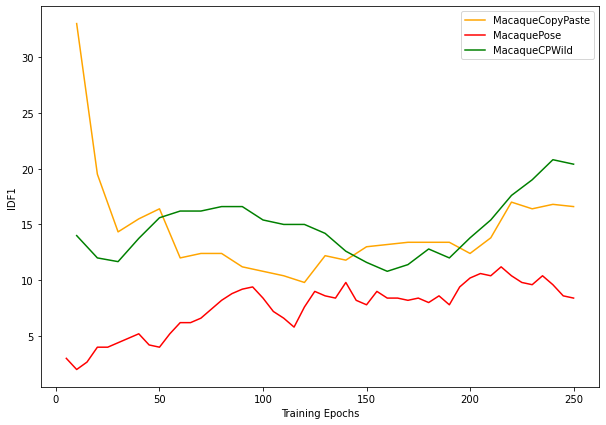

In [112]:
metric = "num_switches_roll"

#subset1 = output[(output.pretrain == "human") & (output.model == "mcqcp")]
subset2 = output[(output.pretrain == "z") & (output.model == "mcqcp")]
subset3 = output[output.model == "mcqpose"]
subset3['epoch'] /= 2
subset4 = output[output.model == "mcqcpwild"]

fig, ax = plt.subplots(figsize=(10, 7))
#line1,  = ax.plot(subset1.epoch, subset1[metric], c = "blue")
line2,  = ax.plot(subset2.epoch, subset2[metric], c = "orange")
line3,  = ax.plot(subset3.epoch, subset3[metric], c = "red")
line4,  = ax.plot(subset4.epoch, subset4[metric], c = "green")
#ax.plot(output.epoch, 1 - (output.num_switches / (output.num_switches.max() * 2)))
ax.set_xlabel("Training Epochs")
ax.set_ylabel("IDF1")
ax.legend([line2, line3, line4], ['MacaqueCopyPaste', 'MacaquePose', 'MacaqueCPWild'])

In [115]:
subset2

,mota,num_switches,idf1,epoch,model,pretrain,mota_roll,idf1_roll,num_switches_roll
mcqcp_z_1e4_10,0.510556,33,0.593563,10.0,mcqcp,z,0.510556,0.593563,33.000000
mcqcp_z_1e4_20,0.636940,6,0.755149,20.0,mcqcp,z,0.573748,0.674356,19.500000
mcqcp_z_1e4_30,0.810123,4,0.864599,30.0,mcqcp,z,0.652540,0.737770,14.333333
mcqcp_z_1e4_40,0.783635,19,0.850132,40.0,mcqcp,z,0.685314,0.765861,15.500000
mcqcp_z_1e4_50,0.822126,20,0.895898,50.0,mcqcp,z,0.712676,0.791868,16.400000
mcqcp_z_1e4_60,0.756162,11,0.819724,60.0,mcqcp,z,0.761797,0.837100,12.000000
mcqcp_z_1e4_70,0.817145,8,0.899614,70.0,mcqcp,z,0.797838,0.865993,12.400000
mcqcp_z_1e4_80,0.834448,4,0.908571,80.0,mcqcp,z,0.802703,0.874788,12.400000
mcqcp_z_1e4_90,0.816621,13,0.888381,90.0,mcqcp,z,0.809300,0.882438,11.200000
mcqcp_z_1e4_100,0.824486,18,0.862233,100.0,mcqcp,z,0.809772,0.875705,10.800000


## Cross-Validation with wild videos

In [1536]:
path = "/usr/users/agecker/datasets/macaque_videos/"

vids = os.listdir(path)

regex = re.compile('VID_.*')
vids = [i for i in vids if regex.match(i)]
vids

['VID_20210223_123630_0',
 'VID_20210224_114038_0',
 'VID_20210224_115729_0',
 'VID_20210223_123817_0',
 'VID_20210224_115455_0',
 'VID_20210223_123854_0']

In [1537]:
for i, vid in enumerate(vids):
    models = ['wild'+str(i)+"_" + str(elem) for elem in [3,6,9,12]]
    all_models = []
    for model in models:
        summary = evaluate_model(model, [vid]).iloc[-1:,:]
        summary.index = [model]
        all_models.append(summary)
        
    print(all_models)

[             mota  num_switches     idf1
wild0_3  0.551676             5  0.71777,              mota  num_switches      idf1
wild0_6  0.618017             4  0.808539,              mota  num_switches      idf1
wild0_9  0.618715             8  0.688547,               mota  num_switches      idf1
wild0_12  0.773743             9  0.802124]
[             mota  num_switches      idf1
wild1_3  0.564399             0  0.721554,              mota  num_switches      idf1
wild1_6  0.564399             0  0.721554,              mota  num_switches      idf1
wild1_9  0.959479             0  0.979321,               mota  num_switches      idf1
wild1_12  0.959479             0  0.979321]
[             mota  num_switches      idf1
wild2_3  0.948989             0  0.974917,              mota  num_switches      idf1
wild2_6  0.959577             0  0.980076,              mota  num_switches     idf1
wild2_9  0.960539             0  0.98056,               mota  num_switches     idf1
wild2_12  0.954764  

## Thresholds

We have three thresholds which can be tuned for a better detection / tracking result. We will tweak them with the currently best model mcq180.pth to see if we can improve performance even further.
- Confidence threshold: From the heatmap + width/height, a confidence for the bounding box is calculated (how exactly?) - with the confidence threshold we can filter out more or less boxes.
- Embedding similarity threshold: When a new frame is analyzed we look at the embedding of the center point of an object. Then we compare this embedding to all the embeddings of center points of objects in prior frames and match them if they are closer than this threshold.
- IoU similarity threshold: Same as embedding similarity threshold, but now with IoU between current detections and detections in prior frames.

In [57]:
combs = []

for c in [0.02]:
    for e in [0.3]:
        for i in [0.3, 0.4, 0.5, 0.6, 0.7]:
            for t in [0.5]:
                combs.append("mcqcpz120_"+str(c)+"_"+str(e)+"_"+str(i)+"_"+str(t))

In [58]:
all_models = []

for model in combs:
    summary = evaluate_model(model, seqs, path = "thresholds/").iloc[-1:,:]
    summary.index = [model]
    all_models.append(summary)
    

output = pd.concat(all_models)
output

,mota,num_switches,idf1
mcqcpz120_0.02_0.3_0.3_0.5,0.836283,13,0.878776
mcqcpz120_0.02_0.3_0.4_0.5,0.836283,13,0.878776
mcqcpz120_0.02_0.3_0.5_0.5,0.844278,14,0.854714
mcqcpz120_0.02_0.3_0.6_0.5,0.841001,10,0.852200
mcqcpz120_0.02_0.3_0.7_0.5,0.831433,10,0.833171


In [118]:
summary = output
summary['index1'] = summary.index

summary['confidence'] = summary['index1'].str.split("_").map(lambda x: x[1]).astype(float)
summary['embedding_sim'] = summary['index1'].str.split("_").map(lambda x: x[2]).astype(float)
summary['new_det'] = summary['index1'].str.split("_").map(lambda x: x[4]).astype(float)

summary = summary.drop(columns = ['index1'])

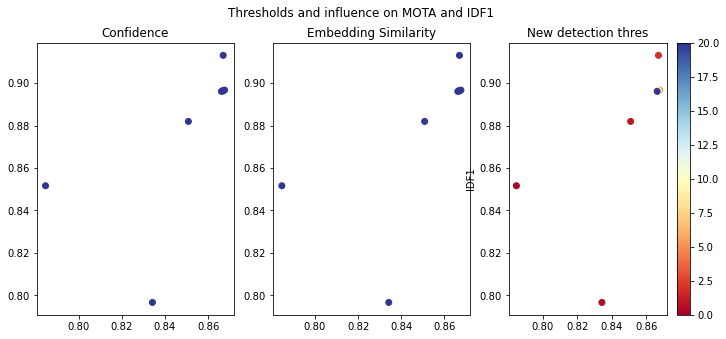

In [119]:
cm = plt.cm.get_cmap('RdYlBu')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,5))
fig.suptitle('Thresholds and influence on MOTA and IDF1')

ax1.scatter(summary.mota, summary.idf1, 
                 c = summary.confidence, cmap=cm, vmin = 0)
ax1.set_title("Confidence")

ax2.scatter(summary.mota, summary.idf1, 
                 c = summary.embedding_sim, cmap=cm, vmin = 0)
ax2.set_title("Embedding Similarity")

cm = ax3.scatter(summary.mota, summary.idf1, 
                 c = summary.new_det, cmap=cm, vmin = 0)
ax3.set_ylabel("IDF1")
ax3.set_title("New detection thres")

plt.colorbar(cm)